# Model creation to classify a special click noise 

In [1]:
import numpy as np
import random
from scipy.signal import spectrogram, stft
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, matthews_corrcoef

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import GaussianNoise, ReLU, LeakyReLU, MaxPooling2D,Conv2D, GRU, GlobalAveragePooling1D, MaxPooling1D, LSTM, Dense, Conv1D, AveragePooling1D, Input, Dropout, BatchNormalization, Activation, Flatten, BatchNormalization, concatenate, Convolution2D
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l2, l1, l1_l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD

import metrics

Using TensorFlow backend.


In [2]:
SEED = 42
FOLDS = 5
PATIENCE = 100
BATCH_SIZE = 32
EPOCHS = 100
VAL_SPLIT = 0.1
TEST_SPLIT = 0.2
CHECKPOINT = "model_cp"
METRICS = ['accuracy', metrics.recall, metrics.precision, metrics.f1, metrics.mcor]
LOG_DIR = "ICIS_logs/strat_test"

In [3]:
tensorboard = TensorBoard(log_dir=LOG_DIR,
                          histogram_freq=0,
                          batch_size=BATCH_SIZE,
                          write_graph=False,
                          write_grads=False,
                          write_images=False,
                          embeddings_freq=0,
                          embeddings_layer_names=None,
                          embeddings_metadata=None)

ES = EarlyStopping(monitor='val_loss', 
                   min_delta=0,
                   patience=PATIENCE, 
                   verbose=0, 
                   mode='auto', 
                   baseline=None, 
                   restore_best_weights=False)

cp = ModelCheckpoint(filepath=CHECKPOINT,
                     monitor='val_loss',
                     verbose=0,
                     save_best_only=True,
                     save_weights_only=False,
                     mode='auto',
                     period=1)

### Load data

In [4]:
x_niko = np.load("data/raw/x_niko.npy")
x_adrian = np.load("data/raw/x_adrian.npy")
x_toni = np.load("data/raw/x_toni.npy")
x_adrian2 = np.load("data/raw/x_adrian2.npy")
x_adrian3 = np.load("data/raw/x_adrian3.npy")
x_raw = np.concatenate((x_adrian, x_niko,x_toni,x_adrian2,x_adrian3), axis=0)

In [5]:
y_niko = np.load("data/raw/y_niko.npy")
y_adrian = np.load("data/raw/y_adrian.npy")
y_toni = np.load("data/raw/y_toni.npy")
y_adrian2 = np.load("data/raw/y_adrian2.npy")
y_adrian3 = np.load("data/raw/y_adrian3.npy")
y_raw = np.concatenate((y_adrian, y_niko,y_toni,np.squeeze(y_adrian2),y_adrian3))

### Example

In [5]:
neg_example = random.sample(list(np.where(y_raw==0)[0]),1)[0]
pos_example = random.sample(list(np.where(y_raw==1)[0]),1)[0]

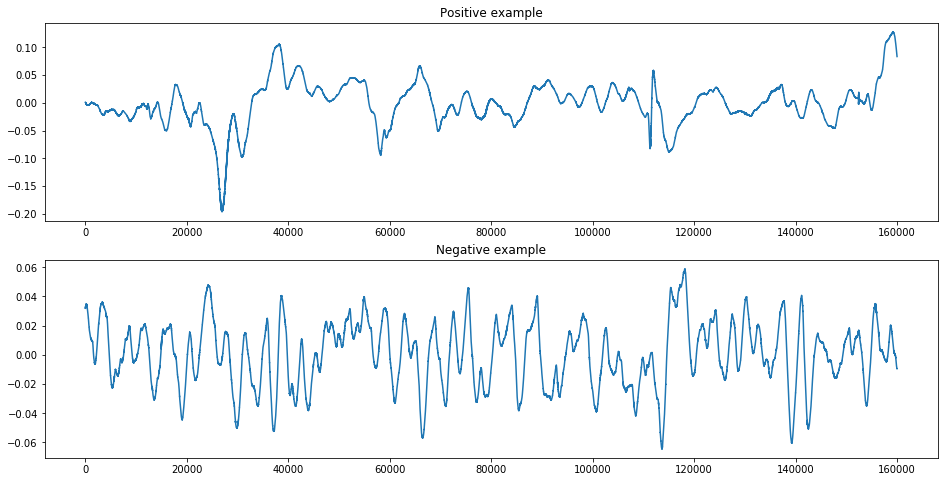

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(16,8))
axes[0].plot(x_raw[pos_example])
axes[0].set_title('Positive example')
axes[1].plot(x_raw[neg_example])
axes[1].set_title('Negative example')  
_ = fig

### Plot data using spectrogram function

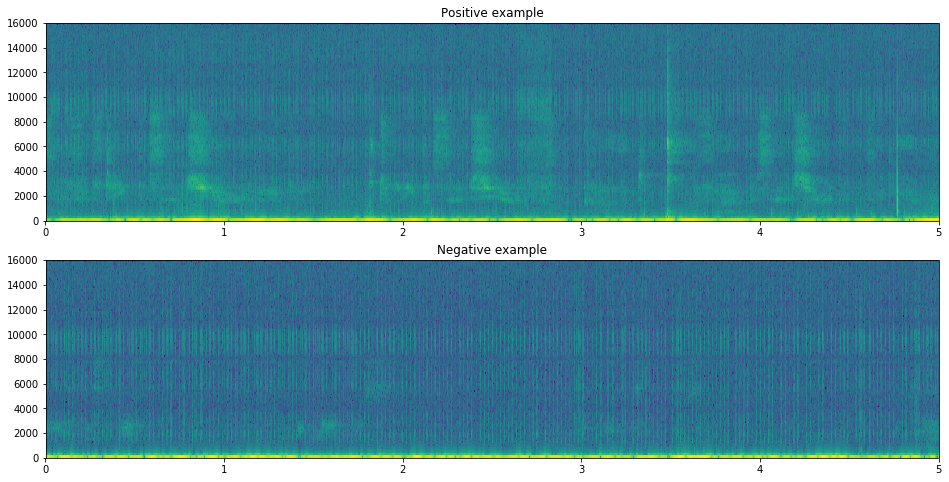

In [8]:
nfft=256
fs=32000

# spectrum : 2-D array Columns are the periodograms of successive segments.
# freqs : 1-D array  The frequencies corresponding to the rows in *spectrum*.
# t : 1-D array  The times corresponding to midpoints of segments (i.e., the columnsin *spectrum*).
# im : instance of class :class:`~matplotlib.image.AxesImage`  The image created by imshow containing the spectrogram

fig, axes = plt.subplots(2, 1,figsize=(16,8))
axes[0].specgram(x_raw[pos_example], Fs=fs, NFFT=nfft)
axes[0].set_title('Positive example')
axes[1].specgram(x_raw[neg_example], Fs=fs, NFFT=nfft) #scale='linear'
axes[1].set_title('Negative example')
_ = fig

### Fourier Transformation

In [9]:
four_lst = [stft(x,fs=fs,nfft=nfft) for x in list(x_raw)]
x_four = np.abs(np.asarray([four_lst[i][2] for i in range(len(four_lst))]))

In [4]:
x_four = np.load("x_four.npz")
y_raw = np.load("y.npz")

#### Use log scale

In [6]:
x_log = 10. * np.log10(x_four+np.finfo(float).eps) # from plt.spectrogram

NameError: name 'four_lst' is not defined

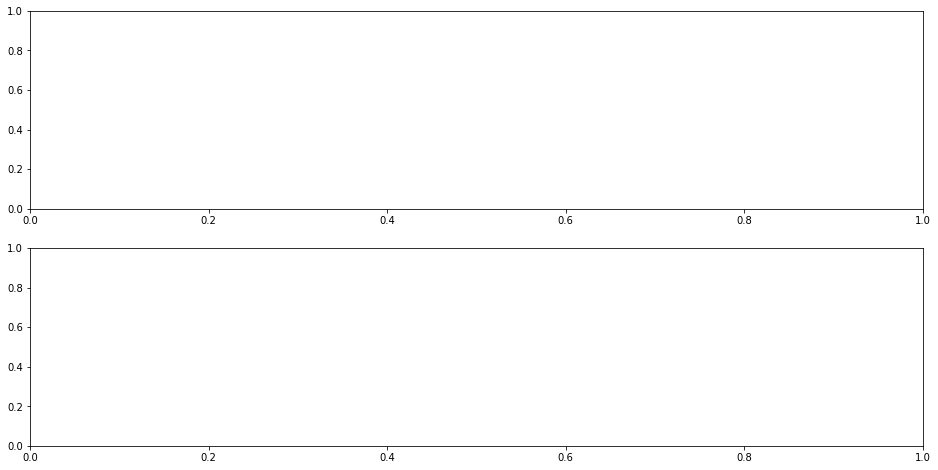

In [7]:
fig, axes = plt.subplots(2, 1,figsize=(16,8))
axes[0].pcolormesh(four_lst[pos_example][1], four_lst[pos_example][0], x_log[pos_example])
axes[0].set_title('Positive example')
axes[1].pcolormesh(four_lst[neg_example][1], four_lst[neg_example][0], x_log[neg_example])
axes[1].set_title('Negative example')
_=fig

In [ ]:
fig, axes = plt.subplots(2, 1,figsize=(16,8))
axes[0].pcolormesh(x_four[pos_example])
axes[0].set_title('Positive example')
axes[1].pcolormesh(x_four[neg_example])
axes[1].set_title('Negative example')
_=fig

#### Compare results (not totally equal so far)

In [14]:
# spectrum, _, _, _= plt.specgram(x_raw[neg_example], Fs=fs, NFFT=nfft)
# _,_,Zxx = stft(fs=fs, x=x_raw[neg_example], nfft=nfft)
# np.array_equal(np.log10(np.abs(Zxx)), spectrum)

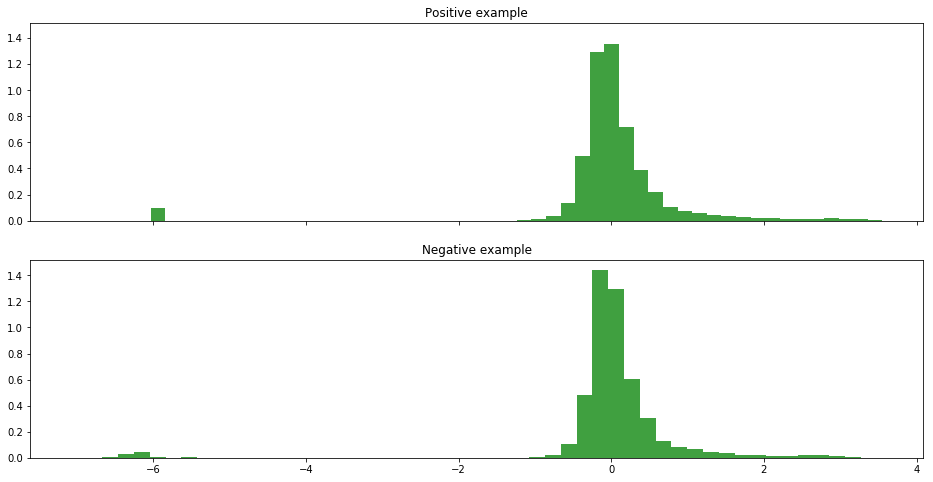

In [8]:
# Problematische Messungen: 460

x1 = np.log10(x_four[460]+np.finfo(float).eps).flatten()
arr = x_four[460]
arr[arr == 0] = np.finfo(float).eps
x2 = np.log10(arr.flatten())

sd1 = np.std(x1)
sd2 = np.std(x2)

m1 = x1.mean()
m2 = x2.mean()

fig, axes = plt.subplots(2, 1,figsize=(16,8), sharex=True, sharey=True)
axes[0].hist((x1-m1)/sd1, 50, density=True, facecolor='g', alpha=0.75)
axes[0].set_title('Positive example')
axes[1].hist((x2-m2)/sd2, 50, density=True, facecolor='g', alpha=0.75)
axes[1].set_title('Negative example')
_=fig

### Split data

In [9]:
x_shape = x_log.reshape((x_log.shape[0],x_log.shape[1],x_log.shape[2], 1))

In [10]:
x_shape = x_shape[:,:,:-1,:]

#### Norm data

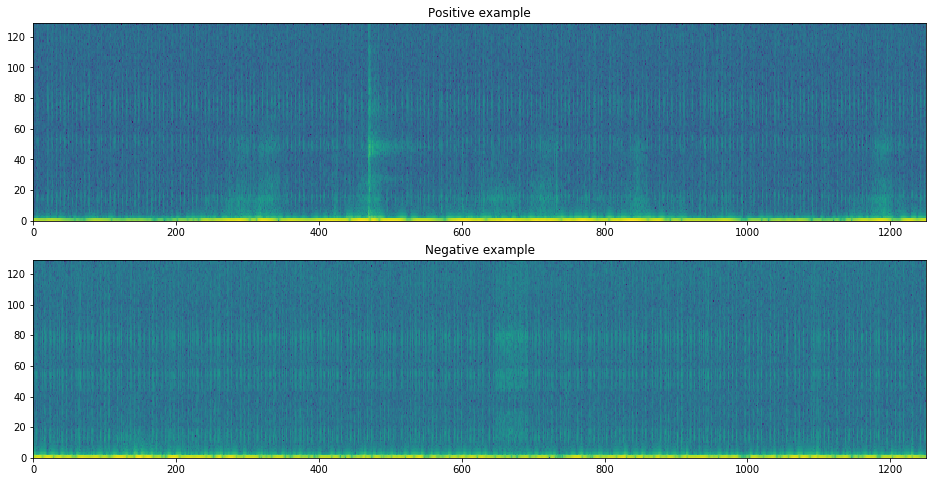

In [11]:
fig, axes = plt.subplots(2, 1,figsize=(16,8))
axes[0].pcolormesh(x_shape[pos_example,:,:,-1])
axes[0].set_title('Positive example')
axes[1].pcolormesh(x_shape[neg_example,:,:,-1])
axes[1].set_title('Negative example')
_=fig

From https://www.researchgate.net/post/What_is_the_correct_way_of_normalizing_an_audio_signal:
- It really depends on what the objective of the normalisation is. Unless you have some way of explicitly calibrating the sound pressure level to which a quantisation level corresponds, you probably don't want to overcomplicate it. I would also suggest that normalising it to the peak absolute value is not a very useful approach under any circumstances - firstly, you probably have a small DC offset, so you want to first subtract the mean, and secondly, you may have some impulse noise present - which would give you a rather misleading result as you may end up with a very much lower-amplitude signal than you expect.
- You could normalise signal power by computing the average power of the signal and then scaling the signal such that the average power is unity. However, if your signal is music or speech, this will tend to be skewed by quiet parts of the signal - it really only makes sense if the signal has a roughly constant power envelope. There is no 'correct' way to do this which is suitable for all cases.

#### Train-Test Split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_shape, 
                                                    y_raw, 
                                                    test_size=TEST_SPLIT, 
                                                    stratify=y_raw,
                                                    random_state=SEED)

#### Train-Val Split

In [13]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train, y_train, 
                                                    # strafify=y_train, 
                                                    test_size=VAL_SPLIT, random_state=SEED)

#### Normalize

In [14]:
# for internal model split
norm_mean = x_train.mean()
norm_std = x_train.std()
norm_max = x_train.max()

x_train = (x_train-norm_mean)/norm_std
x_test = (x_test-norm_mean)/norm_std

In [15]:
# For manual model split
norm_mean2 = x_train2.mean()
norm_std2 = x_train2.std()
norm_max2 = x_train2.max()

x_train2 = (x_train2-norm_mean2)/norm_std2
x_val2 = (x_val2-norm_mean2)/norm_std2

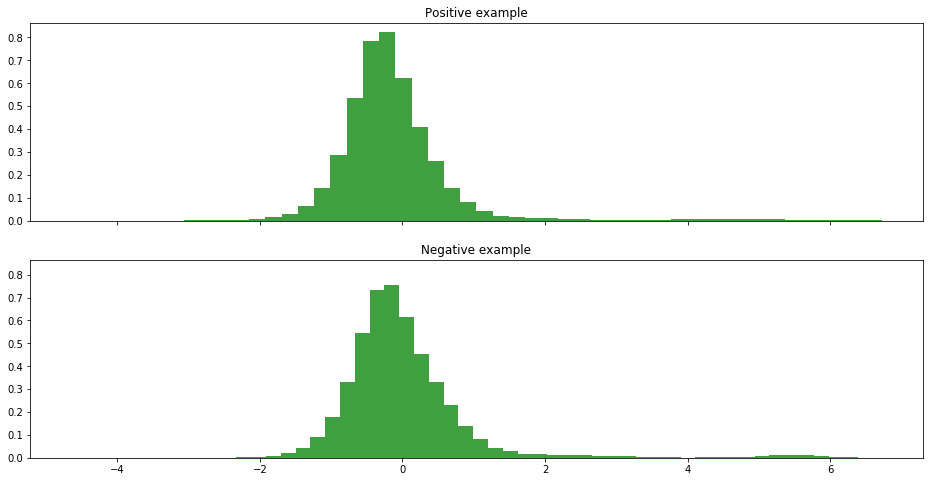

In [16]:
fig, axes = plt.subplots(2, 1,figsize=(16,8), sharex=True, sharey=True)
axes[0].hist(x_train[pos_example,:,:,-1].flatten(), 50, density=True, facecolor='g', alpha=0.75)
axes[0].set_title('Positive example')
axes[1].hist(x_train[neg_example,:,:,-1].flatten(), 50, density=True, facecolor='g', alpha=0.75)
axes[1].set_title('Negative example')
_=fig

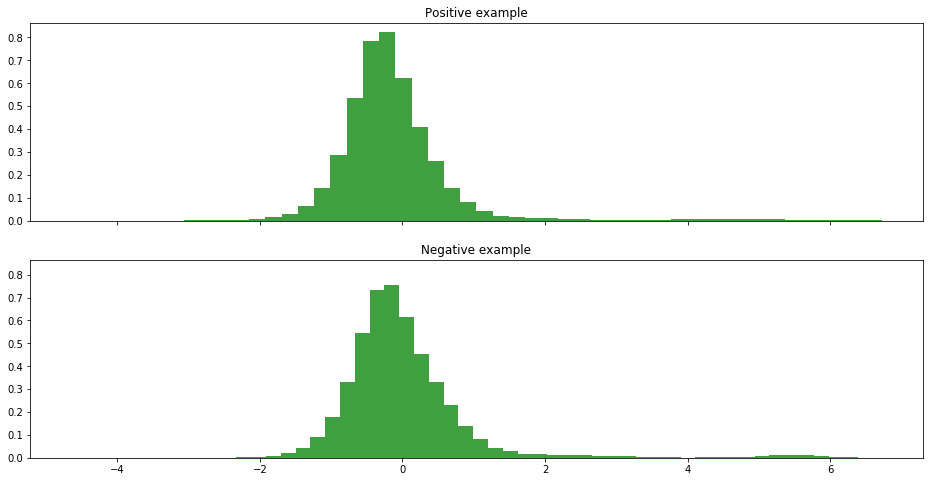

In [17]:
fig, axes = plt.subplots(2, 1,figsize=(16,8), sharex=True, sharey=True)
axes[0].hist(x_train[pos_example,:,:,-1].flatten(), 50, density=True, facecolor='g', alpha=0.75)
axes[0].set_title('Positive example')
axes[1].hist(x_train[neg_example,:,:,-1].flatten(), 50, density=True, facecolor='g', alpha=0.75)
axes[1].set_title('Negative example')
_=fig

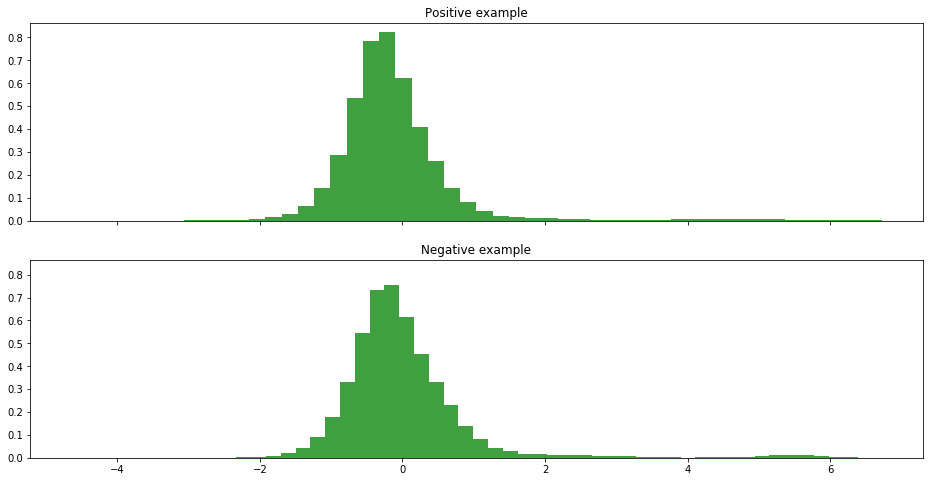

In [18]:
fig, axes = plt.subplots(2, 1,figsize=(16,8), sharex=True, sharey=True)
axes[0].hist(x_train[pos_example,:,:,-1].flatten(), 50, density=True, facecolor='g', alpha=0.75)
axes[0].set_title('Positive example')
axes[1].hist(x_train[neg_example,:,:,-1].flatten(), 50, density=True, facecolor='g', alpha=0.75)
axes[1].set_title('Negative example')
_=fig

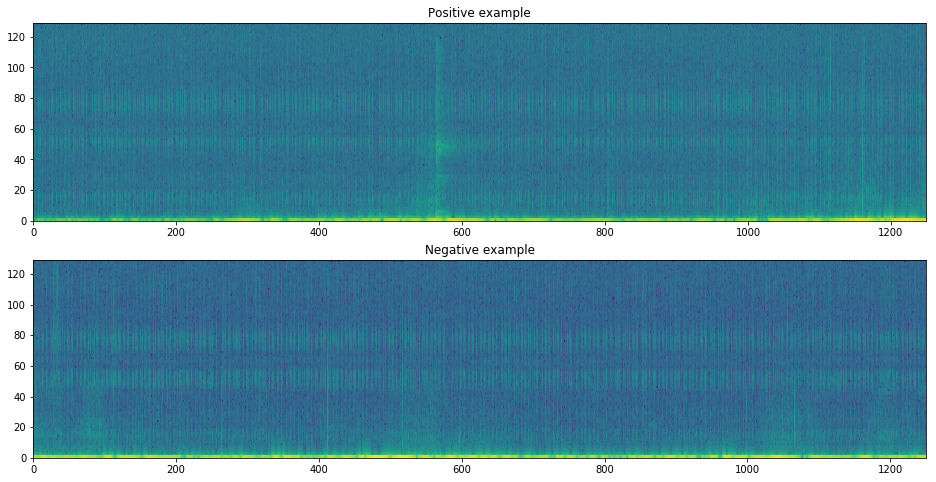

In [20]:
fig, axes = plt.subplots(2, 1,figsize=(16,8))
axes[0].pcolormesh(x_train[pos_example,:,:-1,-1])
axes[0].set_title('Positive example')
axes[1].pcolormesh(x_train[neg_example,:,:,-1])
axes[1].set_title('Negative example')
_=fig

## CNN

In [21]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights = {0: class_weights[0],
                 1: class_weights[1]}

### Use data generater

In [30]:
datagen = ImageDataGenerator(featurewise_center=False, 
                           samplewise_center=False, 
                           featurewise_std_normalization=False, 
                           samplewise_std_normalization=False,
                           zca_whitening=False, 
                           zca_epsilon=1e-06, 
                           rotation_range=0, 
                           width_shift_range=0.0, 
                           height_shift_range=0.0, 
                           brightness_range=None, 
                           shear_range=0.0, 
                           zoom_range=0.0, 
                           channel_shift_range=0.0, 
                           fill_mode='nearest', # reflect
                           cval=0.0, 
                           horizontal_flip=False, 
                           vertical_flip=False, 
                           rescale=None, 
                           preprocessing_function=None, 
                           data_format=None, 
                           validation_split=VAL_SPLIT, 
                           dtype=None)

### Model with gauss noise

In [43]:
#gebaut nach https://github.com/DCASE-REPO/dcase2018_baseline/blob/master/task1/task1a.yaml 
def get_gauss_model():
    model = Sequential()
    
    model.add(GaussianNoise( 0.01, input_shape=x_train.shape[-3:]))
    model.add(Conv2D(32, (7, 7), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(5, 5), padding = 'same'))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (7, 7), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 100), padding = 'same'))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  optimizer="adam",                       
                  metrics=METRICS)
    return model

In [44]:
gauss_model = get_gauss_model()

In [45]:
gauss_hist = gauss_model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE,
                                      subset="training", seed=SEED),
                         validation_data=datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, 
                                                      subset="validation", seed=SEED), 
                         steps_per_epoch=len(x_train) / BATCH_SIZE, 
                         epochs=EPOCHS,
                         callbacks=[ES, tensorboard],
                         validation_steps= len(x_train)/BATCH_SIZE*VAL_SPLIT,
                         class_weight = class_weights)

Epoch 1/100
110/109 [==============================] - 11s 104ms/step - loss: 0.7765 - acc: 0.6566 - recall: 0.6367 - precision: 0.5324 - f1: nan - mcor: 0.3106 - val_loss: 0.3155 - val_acc: 0.9114 - val_recall: 0.7599 - val_precision: 0.9479 - val_f1: 0.8387 - val_mcor: 0.7926
Epoch 2/100
110/109 [==============================] - 11s 99ms/step - loss: 0.3153 - acc: 0.8774 - recall: 0.8648 - precision: 0.8164 - f1: 0.8277 - mcor: 0.7446 - val_loss: 0.1409 - val_acc: 0.9571 - val_recall: 0.9106 - val_precision: 0.9539 - val_f1: 0.9266 - val_mcor: 0.8998
Epoch 3/100
110/109 [==============================] - 11s 99ms/step - loss: 0.2322 - acc: 0.9265 - recall: 0.9228 - precision: 0.8806 - f1: 0.8948 - mcor: 0.8444 - val_loss: 0.1307 - val_acc: 0.9571 - val_recall: 0.9532 - val_precision: 0.9163 - val_f1: 0.9319 - val_mcor: 0.9025
Epoch 4/100
110/109 [==============================] - 11s 99ms/step - loss: 0.2012 - acc: 0.9295 - recall: 0.9239 - precision: 0.8872 - f1: 0.9003 - mcor: 0.8

KeyboardInterrupt: 

In [ ]:
# model eval
y_pred = gauss_model.predict_classes(x_test, verbose=1, batch_size=BATCH_SIZE) 
print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

### ohne weighting

In [47]:
gauss_model2 = get_gauss_model()

In [ ]:
gauss_hist2 = gauss_model2.fit(x_train2, y_train2, 
               batch_size = BATCH_SIZE, 
               epochs=EPOCHS, 
               validation_data=(x_val,y_val),
               callbacks=[ES, tensorboard]
               # ,class_weight=class_weights
               )

In [48]:
# gauss_model2.save("gauss_model2stra_unbal.h5")
gauss_model2.load_weights("gauss_model2stra_unbal.h5")

In [49]:
y_pred = gauss_model2.predict_classes(x_test, verbose=1, batch_size=BATCH_SIZE) 
print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

875/875 [==============================] - 2s 2ms/step
0.9925654299683635
[[569   1]
 [  4 301]]


In [50]:
res = [type(gauss_model2).__name__,
       balanced_accuracy_score(y_test, y_pred)*100,
       precision_score(y_test, y_pred)*100,
       recall_score(y_test, y_pred)*100,
       f1_score(y_test, y_pred)*100,
       matthews_corrcoef(y_test, y_pred)*100]
res

['Sequential',
 99.25654299683634,
 99.66887417218543,
 98.68852459016394,
 99.17627677100495,
 98.74167473584073]